In [17]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')

import pandas_datareader.data as web  #Pandas Datareader
import matplotlib.pyplot as plt  
import mplfinance as mpf
from matplotlib.widgets import RangeSlider
import matplotlib.dates as dates
from mpl_toolkits.mplot3d import Axes3D
import pandas_datareader.data as web



import nolds
import pandas as pd
import numpy as np
import math
from fbm import *
from fbm import FBM
from tqdm import tqdm
import pandas as pd
import plotly.graph_objects as go

from datetime import datetime

import statsmodels.api as sm

from scipy.optimize import fsolve
from scipy import stats

import random

In [18]:
#ASSET
series_id  = 'DCOILBRENTEU'
#DATES
start_date = datetime(1994, 8, 31)
end_date = datetime(2024, 7, 1)

data =  web.DataReader(series_id, 'fred', start_date, end_date)

data


,DCOILBRENTEU
DATE,
1994-08-31,16.03
1994-09-01,16.03
1994-09-02,15.88
1994-09-05,15.60
1994-09-06,15.95
...,...
2024-06-25,86.81
2024-06-26,85.76
2024-06-27,87.00


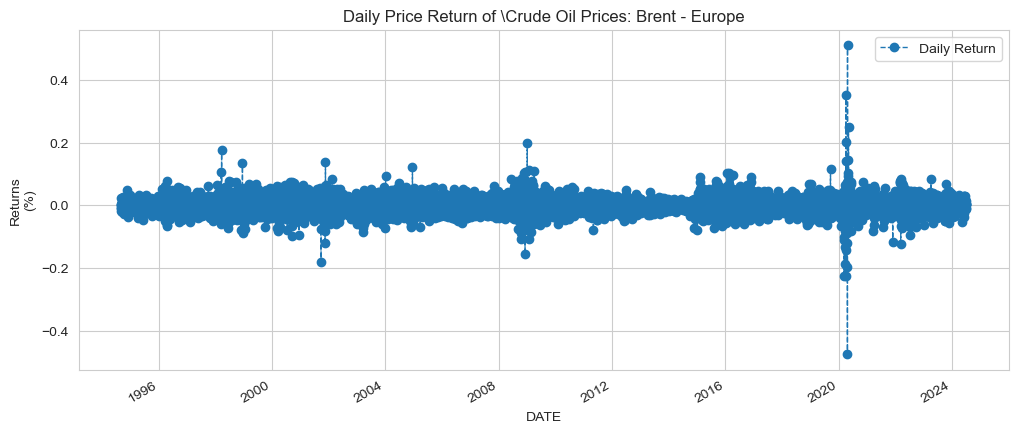

In [19]:
data = data.dropna()
# use pct_change to find the percent change for each day
data['Daily Return'] = data['DCOILBRENTEU'].pct_change()
# plot the daily return percentage
plt.xlabel('Date')
plt.ylabel('Returns\n(%)')
plt.title("Daily Price Return of \Crude Oil Prices: Brent - Europe")
data['Daily Return'].plot(figsize=(12,5),legend=True,linestyle='--',linewidth='1', marker='o')
plt.show()

In [29]:
data['Daily Return'].describe()

count    7560.000000
mean        0.000549
std         0.025423
min        -0.474654
25%        -0.011558
50%         0.000724
75%         0.012828
max         0.509868
Name: Daily Return, dtype: float64

In [22]:
from numpy.random import normal
from math import log, pi, sqrt, exp
from statistics import variance
from scipy.stats import norm, jarque_bera, anderson
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

#############
#  GENERAL  #
#############

def llhngarch(par, ts=None, r_f=0., symmetric=False):
    # Initialize variables
    h_vec = []
    z_vec = []
    ll = []
    r = r_f
    
    # Transform parameters to ensure positivity
    omega = 1/(1+exp(-par[0]))
    alpha = 1/(1+exp(-par[1]))
    beta = 1/(1+exp(-par[2]))
    gam = par[3] if not symmetric else 0
    lam = par[4]
    
    # Barrier function to ensure stationarity
    if beta + (alpha * gam * gam) > 1:
        return 1e50
    
    h = variance(ts)
    h_vec.append(h)
    z = (ts[0] - r - lam * h)/sqrt(h)
    z_vec.append(z)
    
    try:
        l = log(norm.pdf(z)/sqrt(h))
    except:
        l = 1e50
    ll.append(l)
    
    for i in range(1, len(ts)):
        h = omega + alpha * pow(z - gam * sqrt(h), 2) + beta * h
        h_vec.append(h)
        z = (ts[i] - r - lam * h)/sqrt(h)
        z_vec.append(z)
        try:
            l = log(norm.pdf(z)/sqrt(h))
        except:
            l = 1e50
        ll.append(l)
        
    return -1 * sum(ll)

def A_loop(a, b, r_f, phi, omega, alpha):
    a = a + phi * r_f + b * omega - 0.5 * np.log(1 - 2 * alpha * b)
    return a

def B_loop(b, phi, alpha, beta, gam, lam):
    b = phi * (lam + gam) - 0.5 * gam**2 + beta * b + (0.5*(phi - gam)**2)/(1 - 2 * alpha * b)
    return b       
        
########################
#  Heston-Nandi GARCH  #
########################

class HNGarch:
    def __init__(self, timeseries=None, r_f=0.):
        self.timeseries = list(timeseries)
        self.r_f = r_f
        self.params = None
        self.lr_var = None
        self.gamma_star = None
        self.h_t0 = None
        self.std_errors = None
     
    def GARCH_fit(self, symmetric=False):
        r = self.r_f
        ts = self.timeseries.copy()
        r_t = [log(ts[i]/ts[i-1]) for i in range(1, len(ts))]
        
        # Initial parameter guess
        omega = variance(r_t)
        alpha = 0.1 * variance(r_t)
        beta = 0.1
        gam = 0.0
        lam = -0.5

        omega = -log((1-omega)/omega)
        alpha = -log((1-alpha)/alpha)
        beta = -log((1-beta)/beta)    
    
        par = [omega, alpha, beta, gam, lam]
        res = minimize(llhngarch, par, args=(r_t, r, symmetric), method='L-BFGS-B')

        # Compute standard errors using the inverse Hessian matrix
        hess_inv = res.hess_inv.todense()
        diag = np.diag(hess_inv)
        self.std_errors = np.sqrt(diag)

        omega = (1/(1 + exp(-res.x[0])))
        alpha = (1/(1 + exp(-res.x[1])))
        beta = (1/(1 + exp(-res.x[2])))
        lam = res.x[4]
        gam = res.x[3] if not symmetric else 0.0
        
        self.gamma_star = lam + gam + 0.5
        self.params = omega, alpha, beta, gam, lam
        
        print('Estimation results:')
        print('-------------------')
        print(f'Omega:    {omega}')
        print(f'Alpha:    {alpha}')
        print(f'Beta:     {beta}')
        if not symmetric:
            print(f'Gamma:    {gam}')
        print(f'Lambda:   {lam}')
        
        persistence = beta + alpha * gam**2
        print('\n')
        print(f'Model persistence: {round(persistence, 6)}')
        self.lr_var = (omega + alpha) / (1 - persistence)
        print(f'Long-run variance: {round(self.lr_var, 6)}\n')
        
    def lr_variance(self):
        print('Model variance')
        print('----------------')
        print(f'Daily variance: {round(self.lr_var * 100, 4)}%')
        return self.lr_var
    
    def lr_vol(self):
        print('Model volatility')
        print('----------------')
        print(f'Annualized volatility: {round(sqrt(self.lr_var) * sqrt(252) * 100, 4)}%')
        print(f'Daily volatility:      {round(sqrt(self.lr_var) * 100, 4)}%')
        return sqrt(self.lr_var)

    def get_std_errors(self):
        print('Standard errors for the estimates:')
        print('----------------------------------')
        print(f'omega:  {self.std_errors[0]}')
        print(f'alpha:  {self.std_errors[1]}')
        print(f'beta:   {self.std_errors[2]}')
        print(f'gamma:  {self.std_errors[3]}')
        print(f'lambda: {self.std_errors[4]}')
        return self.std_errors

    def ts_var(self, vec=False):
        ts = self.timeseries.copy()
        r_f = self.r_f
        
        params = self.params
        r_t = [log(ts[i]/ts[i-1]) for i in range(1, len(ts))]
        
        h_vec = []
        h_t = variance(r_t)
        h_vec.append(h_t)
        n = len(r_t)
        
        for i in range(1, n+1):
            z_t = (r_t[i-1] - r_f - params[4] * h_t - params[3] * h_t)**2
            h_t = params[0] + params[1] * z_t / h_t + params[2] * h_t
            h_vec.append(h_t)
             
        self.h_t0 = h_vec[-1]    
        
        if vec:
            return h_vec[:-1]
        else:
            return h_vec[-1]
        
    def hist_simulation(self):
        ts = self.timeseries
        r_f = self.r_f
        
        params = self.params
        r_t = [log(ts[i]/ts[i-1]) for i in range(1, len(ts))]
        
        h_vec = []
        r_vec = []
        
        h_t = variance(r_t)
        z = (r_t[0] - r_f - params[4] * h_t) / sqrt(h_t)
        
        for i in range(1, len(r_t)):
            h_t = params[0] + params[2] * h_t + params[1] * (z - params[3] * sqrt(h_t))**2
            h_vec.append(h_t)
            z = (r_t[i] - r_f - params[4] * h_t) / sqrt(h_t)
            r_vec.append(z)        
        
        residuals = [r/sqrt(v) for r, v in zip(r_vec, h_vec)]
        
        return residuals
    
    def GARCH_single_fc(self, n_steps=252, vec=False):
        params = self.params

        h_t = self.h_t0
        z_star = normal(0, 1)
        s_t = log(self.timeseries[-1])
        s = []

        for i in range(n_steps):
            h_t = params[0] + params[2] * h_t + params[1] * (z_star - params[3] * sqrt(h_t))**2
            z_star = normal(0, 1)
            s_t = s_t + self.r_f - 0.5 * h_t + sqrt(h_t) * z_star
            s.append(exp(s_t))

        if vec:    
            return s
        else:
            return s[-1]
    
    def montecarlo_sim(self, n_reps=5000, n_steps=252):
        res = []
        for i in range(int(n_reps)):
            s = self.GARCH_single_fc(n_steps, vec=False)
            res.append(s)
        return sum(res)/n_reps
    
    def pdf_func(self, x, steps, r=0., up_lim=100, low_lim=0, prec=10000):
        omega, alpha, beta, gam, lam = self.params
        s = self.timeseries[-1]
        h = self.ts_var(vec=False)
        
        hi = float(up_lim - low_lim) / prec
        t = np.linspace(low_lim + hi/2, up_lim - hi/2, prec)
        a = b = 0
        
        for j in range(steps):
            a = A_loop(a, b, r, t, omega, alpha)
            b = B_loop(b, t, alpha, beta, gam, lam)
        
        res = []
        for i in t:
            res.append(exp(a + b * h - (i - x)**2 / (2 * steps * h)))
        
        return sum(res) * hi / sqrt(2 * pi * steps * h)
    
    def cdf_func(self, x, steps, r=0., up_lim=100, low_lim=0, prec=10000):
        omega, alpha, beta, gam, lam = self.params
        s = self.timeseries[-1]
        h = self.ts_var(vec=False)
        
        hi = float(up_lim - low_lim) / prec
        t = np.linspace(low_lim + hi/2, up_lim - hi/2, prec)
        a = b = 0
        
        for j in range(steps):
            a = A_loop(a, b, r, t, omega, alpha)
            b = B_loop(b, t, alpha, beta, gam, lam)
        
        res = []
        for i in t:
            res.append(exp(a + b * h - (i - x)**2 / (2 * steps * h)))
        
        return sum(res) * hi / sqrt(2 * pi * steps * h)
    
    ##########################
    #  Visualization Plots   #
    ##########################

    def plot_volatility(self):
        ts = self.timeseries.copy()
        var_vec = self.ts_var(vec=True)
        vol_vec = [sqrt(v) for v in var_vec]
        
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(vol_vec)), vol_vec, label='Estimated Volatility')
        plt.title('Heston-Nandi GARCH Model - Volatility Process')
        plt.xlabel('Time')
        plt.ylabel('Volatility')
        plt.legend()
        plt.show()

    def plot_residuals(self):
        residuals = self.hist_simulation()
        
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(residuals)), residuals, label='Residuals')
        plt.title('Heston-Nandi GARCH Model - Residuals')
        plt.xlabel('Time')
        plt.ylabel('Residuals')
        plt.legend()
        plt.show()
        
        # Residual diagnostics
        jb_test = jarque_bera(residuals)
        ad_test = anderson(residuals)
        print('Jarque-Bera Test:', jb_test)
        print('Anderson-Darling Test:', ad_test)
        
    def plot_monte_carlo(self, n_reps=5000, n_steps=252):
        sim_res = [self.GARCH_single_fc(n_steps, vec=False) for _ in range(n_reps)]
        
        plt.figure(figsize=(10, 5))
        plt.hist(sim_res, bins=50, alpha=0.75, label='Monte Carlo Simulations')
        plt.title('Heston-Nandi GARCH Model - Monte Carlo Simulations')
        plt.xlabel('Simulated Prices')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
        
    def plot_pdf(self, x, steps, r=0., up_lim=100, low_lim=0, prec=10000):
        pdf_vals = [self.pdf_func(i, steps, r, up_lim, low_lim, prec) for i in np.linspace(low_lim, up_lim, prec)]
        x_vals = np.linspace(low_lim, up_lim, prec)
        
        plt.figure(figsize=(10, 5))
        plt.plot(x_vals, pdf_vals, label='PDF')
        plt.title('Heston-Nandi GARCH Model - Probability Density Function')
        plt.xlabel('Log-Price')
        plt.ylabel('Density')
        plt.legend()
        plt.show()
        
    def plot_cdf(self, x, steps, r=0., up_lim=100, low_lim=0, prec=10000):
        cdf_vals = [self.cdf_func(i, steps, r, up_lim, low_lim, prec) for i in np.linspace(low_lim, up_lim, prec)]
        x_vals = np.linspace(low_lim, up_lim, prec)
        
        plt.figure(figsize=(10, 5))
        plt.plot(x_vals, cdf_vals, label='CDF')
        plt.title('Heston-Nandi GARCH Model - Cumulative Distribution Function')
        plt.xlabel('Log-Price')
        plt.ylabel('Cumulative Probability')
        plt.legend()
        plt.show()
        
# Example usage:
# timeseries = [your_timeseries_data]
# model = HNGarch(timeseries)
# model.GARCH_fit()
# model.plot_volatility()
# model.plot_residuals()
# model.plot_monte_carlo()
# model.plot_pdf(x, steps)
# model.plot_cdf(x, steps)


Estimation results:
-------------------
Omega:    2.0647510451410028e-27
Alpha:    2.962163348258155e-05
Beta:     0.9097694643960462
Gamma:    33.69783859730161
Lambda:   0.4252719542772712


Model persistence: 0.943406
Long-run variance: 0.000523



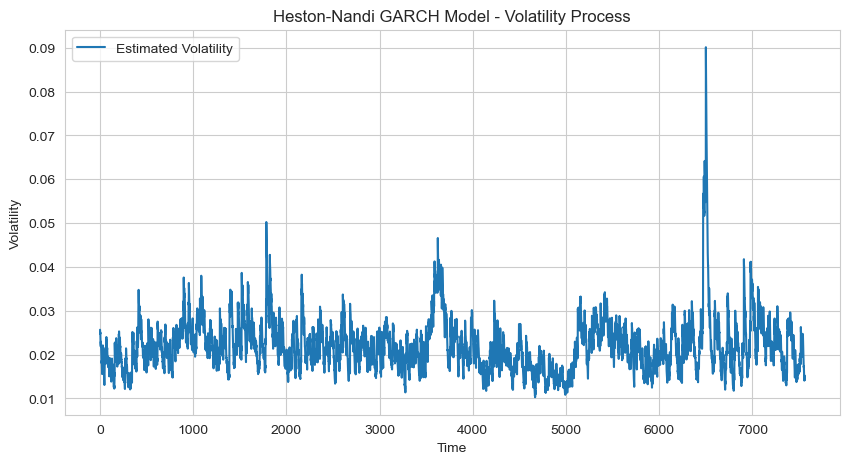

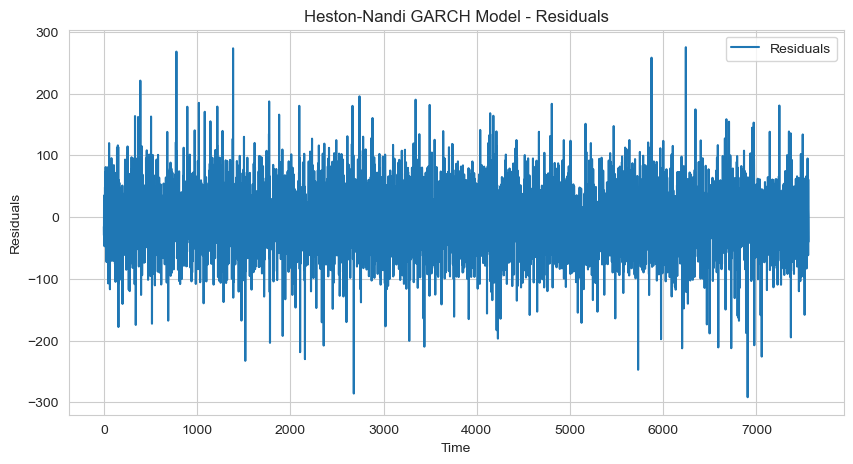

Jarque-Bera Test: SignificanceResult(statistic=1734.1222261413295, pvalue=0.0)
Anderson-Darling Test: AndersonResult(statistic=26.376263484762603, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.4904242979205477, scale=47.95504715067292)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


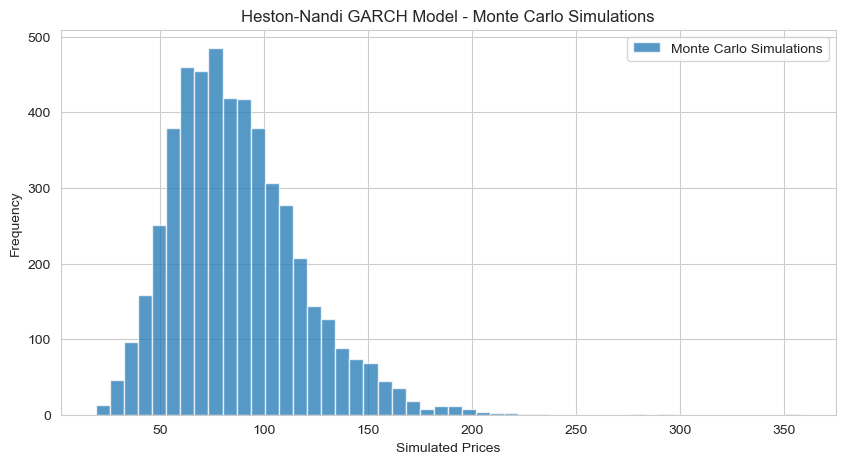

In [23]:
# Example usage:
timeseries = data.DCOILBRENTEU
model = HNGarch(timeseries)
model.GARCH_fit()
model.plot_volatility()
model.plot_residuals()
model.plot_monte_carlo()
#model.plot_pdf(x, steps) 
#model.plot_cdf(x, steps)

In [38]:
x = np.arange(-5, np.log(7000), 0.01)
x[x==0] = 1e-10
steps = 252
model.plot_pdf(x, steps) 
model.plot_cdf(x, steps)

TypeError: only length-1 arrays can be converted to Python scalars

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Example x range
x_range = np.linspace(-0.5, 0.5, 100)  # Adjust this range as needed

# Plot PDF for the given x range and steps
def plot_pdf_range(model, x_range, steps, r=0., up_lim=100, low_lim=0, prec=10000):
    pdf_vals = [model.pdf_func(float(x), steps, r, up_lim, low_lim, prec) for x in x_range]
    plt.figure(figsize=(10, 5))
    plt.plot(x_range, pdf_vals, label='PDF')
    plt.title('Heston-Nandi GARCH Model - Probability Density Function')
    plt.xlabel('Log-Price')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Plot CDF for the given x range and steps
def plot_cdf_range(model, x_range, steps, r=0., up_lim=100, low_lim=0, prec=10000):
    cdf_vals = [model.cdf_func(float(x), steps, r, up_lim, low_lim, prec) for x in x_range]
    plt.figure(figsize=(10, 5))
    plt.plot(x_range, cdf_vals, label='CDF')
    plt.title('Heston-Nandi GARCH Model - Cumulative Distribution Function')
    plt.xlabel('Log-Price')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.show()

# Example usage with a specific model instance and step count
steps = 252  # Adjust the number of steps as needed
plot_pdf_range(model, x_range, steps)
plot_cdf_range(model, x_range, steps)


TypeError: only length-1 arrays can be converted to Python scalars

In [39]:
# Choose a range of x values
x_values = np.linspace(-0.5, 0.5, 100)  # Example range for log-returns

# Number of steps into the future (e.g., 252 trading days for one year)
steps = 252

# Plot the PDF and CDF for each x value in the range
for x in x_values:
    model.plot_pdf(x, steps)
    model.plot_cdf(x, steps)


TypeError: only length-1 arrays can be converted to Python scalars

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Example x range
x_range = np.linspace(-0.5, 0.5, 100)  # Adjust this range as needed

# Plot PDF for the given x range and steps
def plot_pdf_range(model, x_range, steps, r=0., up_lim=100, low_lim=0, prec=10000):
    pdf_vals = [model.pdf_func(float(x), steps, r, up_lim, low_lim, prec) for x in x_range]
    plt.figure(figsize=(10, 5))
    plt.plot(x_range, pdf_vals, label='PDF')
    plt.title('Heston-Nandi GARCH Model - Probability Density Function')
    plt.xlabel('Log-Price')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Plot CDF for the given x range and steps
def plot_cdf_range(model, x_range, steps, r=0., up_lim=100, low_lim=0, prec=10000):
    cdf_vals = [model.cdf_func(float(x), steps, r, up_lim, low_lim, prec) for x in x_range]
    plt.figure(figsize=(10, 5))
    plt.plot(x_range, cdf_vals, label='CDF')
    plt.title('Heston-Nandi GARCH Model - Cumulative Distribution Function')
    plt.xlabel('Log-Price')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.show()

# Example usage with a specific model instance and step count
plot_pdf_range(model, x_range, steps)
plot_cdf_range(model, x_range, steps)


TypeError: only length-1 arrays can be converted to Python scalars